In [1]:
import configparser
from talkdata.sql import get_conn
from talkdata.sql import init_tables_if_not_exist
from talkdata.sql import drop_all_the_data
from talkdata.sql import fill_training_in_db
from talkdata.sql import fill_test_in_db


config_path = "/home/jl237561/workspace/talkdata/config/is222239.ini"
config = configparser.ConfigParser()
config.sections()
config.read(config_path)

dbname = config['POSTGRESQL']["dbname"]
username = config['POSTGRESQL']["username"]
password = config['POSTGRESQL']["password"]

training_csv = config['DATA']["training_csv"]
test_csv = config['DATA']["test_csv"]

need_refresh = int(config['DATA']["need_refresh"])

conn = get_conn(dbname=dbname, username=username)
init_tables_if_not_exist(conn)

if need_refresh:
    drop_all_the_data(conn)
    fill_training_in_db(conn, training_csv)
    fill_test_in_db(conn, test_csv)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.
  if sys.path[0] == '':


In [2]:
import pandas as pd
import numpy as np

def get_col_dist_dicts(col_name, is_attributed, conn, last_dicts = {}):
    cur = conn.cursor()
    sql_query = "select %s, count(*) from training "\
        "where is_attributed=%d GROUP BY %s ORDER BY %s DESC;" % (
            col_name, is_attributed, col_name, col_name)
    cur.execute(sql_query)
    rows = cur.fetchall()
    for row in rows:
        col_value = row[0]
        dict_ret = last_dicts.get(col_value, {})
        key = "count_%d" % is_attributed
        dict_ret[key] = row[1]
        last_dicts[col_value] = dict_ret
    return last_dicts

def get_df_dist(col_name, conn):
    last_dicts = {}
    last_dicts = get_col_dist_dicts(col_name, is_attributed=0, conn=conn, last_dicts=last_dicts)
    last_dicts = get_col_dist_dicts(col_name, is_attributed=1, conn=conn, last_dicts=last_dicts)
    
    dicts = []
    for key in last_dicts:
        item_dict = {}
        item_dict["col_val"] = int(key)
        item_dict["count_0"]  = int(last_dicts[key].get("count_0", 1))
        item_dict["count_1"]  = int(last_dicts[key].get("count_1", 1))
        dicts.append(item_dict)
    return pd.DataFrame(dicts)

# col_name = "channel"
# df_channel_dist = get_df_dist(col_name, conn)
# df_channel_dist["count_0_log"] = np.log(df_channel_dist["count_0"])
# df_channel_dist["count_1_log"] = np.log(df_channel_dist["count_1"])

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

cache_df_dist = {}
for col_name in ["channel", "app", "device", "os"]:
    df_dist = get_df_dist(col_name, conn)
    df_dist["count_0_log"] = np.log(df_dist["count_0"])
    df_dist["count_1_log"] = np.log(df_dist["count_1"])
    cache_df_dist[col_name] = df_dist


In [13]:
clean_cache_df_dist = {}
for col_name in cache_df_dist:
    cur_df = cache_df_dist[col_name]
    clean_cache_df_dist[col_name] = cur_df.loc[
        (cur_df["count_0"]>=3) &
        (cur_df["count_1"]>=3) &
        (cur_df["count_1"]/cur_df["count_0"]> 0.05)
    ]

In [14]:
clean_cache_df_dist["app"]["col_val"].describe()

count    104.000000
mean     210.769231
std      155.619478
min        0.000000
25%       97.500000
50%      169.000000
75%      305.000000
max      768.000000
Name: col_val, dtype: float64

In [17]:
useful_items = {}
for col_name in ["channel", "app", "device", "os"]:
    df_dist = clean_cache_df_dist[col_name]
    useful_items[col_name] = df_dist["col_val"].tolist()


In [ ]:
training_csv
is_header = True
headers = None
fout = open("/tmp/new_training.csv", "w+")

total_line = 0
for line in open(training_csv, "r"):
    total_line += 1

nline = 0
skip_line = 0
for line in open(training_csv, "r"):
    if is_header:
        is_header = False
        headers = line.split(",")
        fout.write(line)
        continue
    is_keep = False
    words = line.split(",")
    for col_name in ["channel", "app", "device", "os"]:
        col_idx = headers.index("channel")
        col_val = int(words[col_idx])
        if col_val in useful_items[col_name]:
            is_keep = True
            break
    if is_keep:
        fout.write(line)
    else:
        skip_line += 1
    nline += 1
    if nline % 100000 == 0:
        print "%d/%d (%f), skip=%d" % (nline, total_line, float(nline)/float(total_line), skip_line)

100000/184903891 (0.000541), skip=24443
200000/184903891 (0.001082), skip=49915
300000/184903891 (0.001622), skip=77598
400000/184903891 (0.002163), skip=104449
500000/184903891 (0.002704), skip=130346
600000/184903891 (0.003245), skip=156702
700000/184903891 (0.003786), skip=183171
800000/184903891 (0.004327), skip=209618
900000/184903891 (0.004867), skip=235548
1000000/184903891 (0.005408), skip=262130
1100000/184903891 (0.005949), skip=288588
1200000/184903891 (0.006490), skip=312865
1300000/184903891 (0.007031), skip=339008
1400000/184903891 (0.007572), skip=364029
1500000/184903891 (0.008112), skip=389032
1600000/184903891 (0.008653), skip=416145
1700000/184903891 (0.009194), skip=442791
1800000/184903891 (0.009735), skip=468550
1900000/184903891 (0.010276), skip=494773
2000000/184903891 (0.010816), skip=521410
2100000/184903891 (0.011357), skip=546362
2200000/184903891 (0.011898), skip=573411
2300000/184903891 (0.012439), skip=600237
2400000/184903891 (0.012980), skip=627306
2500

19100000/184903891 (0.103297), skip=4444774
19200000/184903891 (0.103838), skip=4464435
19300000/184903891 (0.104379), skip=4484722
19400000/184903891 (0.104919), skip=4506904
19500000/184903891 (0.105460), skip=4526539
19600000/184903891 (0.106001), skip=4546793
19700000/184903891 (0.106542), skip=4567188
19800000/184903891 (0.107083), skip=4586669
19900000/184903891 (0.107623), skip=4607609
20000000/184903891 (0.108164), skip=4629401
20100000/184903891 (0.108705), skip=4649616
20200000/184903891 (0.109246), skip=4669217
20300000/184903891 (0.109787), skip=4688768
20400000/184903891 (0.110328), skip=4708836
20500000/184903891 (0.110868), skip=4728577
20600000/184903891 (0.111409), skip=4748439
20700000/184903891 (0.111950), skip=4768618
20800000/184903891 (0.112491), skip=4788054
20900000/184903891 (0.113032), skip=4807502
21000000/184903891 (0.113573), skip=4827127
21100000/184903891 (0.114113), skip=4847823
21200000/184903891 (0.114654), skip=4866731
21300000/184903891 (0.115195), s

37800000/184903891 (0.204431), skip=8363461
37900000/184903891 (0.204971), skip=8385464
38000000/184903891 (0.205512), skip=8407526
38100000/184903891 (0.206053), skip=8432034
38200000/184903891 (0.206594), skip=8454814
38300000/184903891 (0.207135), skip=8478640
38400000/184903891 (0.207675), skip=8500288
38500000/184903891 (0.208216), skip=8521988
38600000/184903891 (0.208757), skip=8544781
38700000/184903891 (0.209298), skip=8567047
38800000/184903891 (0.209839), skip=8589394
38900000/184903891 (0.210380), skip=8611387
39000000/184903891 (0.210920), skip=8633730
39100000/184903891 (0.211461), skip=8656963
39200000/184903891 (0.212002), skip=8680180
39300000/184903891 (0.212543), skip=8703297
39400000/184903891 (0.213084), skip=8725411
39500000/184903891 (0.213624), skip=8747308
39600000/184903891 (0.214165), skip=8768610
39700000/184903891 (0.214706), skip=8790086
39800000/184903891 (0.215247), skip=8812269
39900000/184903891 (0.215788), skip=8836274
40000000/184903891 (0.216329), s

56200000/184903891 (0.303942), skip=12691186
56300000/184903891 (0.304483), skip=12716909
56400000/184903891 (0.305023), skip=12743216
56500000/184903891 (0.305564), skip=12769483
56600000/184903891 (0.306105), skip=12797336
56700000/184903891 (0.306646), skip=12823755
56800000/184903891 (0.307187), skip=12850050
56900000/184903891 (0.307727), skip=12875650
57000000/184903891 (0.308268), skip=12903019
57100000/184903891 (0.308809), skip=12931239
57200000/184903891 (0.309350), skip=12958466
57300000/184903891 (0.309891), skip=12984728
57400000/184903891 (0.310432), skip=13011934
57500000/184903891 (0.310972), skip=13038301
57600000/184903891 (0.311513), skip=13065279
57700000/184903891 (0.312054), skip=13092125
57800000/184903891 (0.312595), skip=13119609
57900000/184903891 (0.313136), skip=13148492
58000000/184903891 (0.313676), skip=13177609
58100000/184903891 (0.314217), skip=13206869
58200000/184903891 (0.314758), skip=13235545
58300000/184903891 (0.315299), skip=13263653
58400000/1

74500000/184903891 (0.402912), skip=17511302
74600000/184903891 (0.403453), skip=17533056
74700000/184903891 (0.403994), skip=17554867
74800000/184903891 (0.404534), skip=17577406
74900000/184903891 (0.405075), skip=17599938
75000000/184903891 (0.405616), skip=17622586
75100000/184903891 (0.406157), skip=17645326
75200000/184903891 (0.406698), skip=17666769
75300000/184903891 (0.407239), skip=17688605
75400000/184903891 (0.407779), skip=17710389
75500000/184903891 (0.408320), skip=17732748
75600000/184903891 (0.408861), skip=17755936
75700000/184903891 (0.409402), skip=17777217
75800000/184903891 (0.409943), skip=17799296
75900000/184903891 (0.410484), skip=17821675
76000000/184903891 (0.411024), skip=17844356
76100000/184903891 (0.411565), skip=17869292
76200000/184903891 (0.412106), skip=17893329
76300000/184903891 (0.412647), skip=17917803
76400000/184903891 (0.413188), skip=17941943
76500000/184903891 (0.413728), skip=17966162
76600000/184903891 (0.414269), skip=17990028
76700000/1

92800000/184903891 (0.501882), skip=21398174
92900000/184903891 (0.502423), skip=21417188
93000000/184903891 (0.502964), skip=21435974
93100000/184903891 (0.503505), skip=21454797
93200000/184903891 (0.504046), skip=21473582
93300000/184903891 (0.504586), skip=21492488
93400000/184903891 (0.505127), skip=21511459
93500000/184903891 (0.505668), skip=21530614
93600000/184903891 (0.506209), skip=21549540
93700000/184903891 (0.506750), skip=21568127
93800000/184903891 (0.507291), skip=21586727
93900000/184903891 (0.507831), skip=21605262
94000000/184903891 (0.508372), skip=21623835
94100000/184903891 (0.508913), skip=21642401
94200000/184903891 (0.509454), skip=21660918
94300000/184903891 (0.509995), skip=21679753
94400000/184903891 (0.510535), skip=21699318
94500000/184903891 (0.511076), skip=21717991
94600000/184903891 (0.511617), skip=21736937
94700000/184903891 (0.512158), skip=21755940
94800000/184903891 (0.512699), skip=21774625
94900000/184903891 (0.513240), skip=21793504
95000000/1

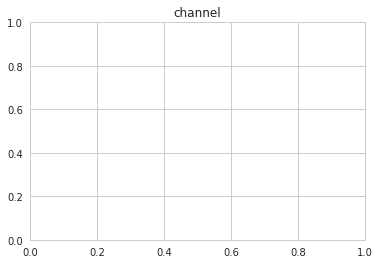

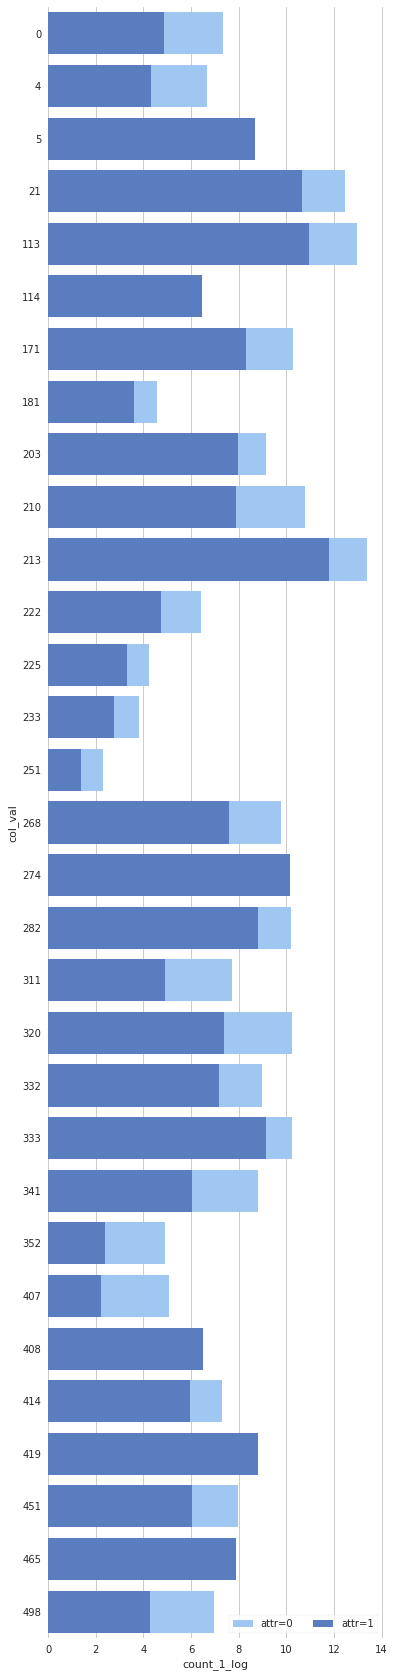

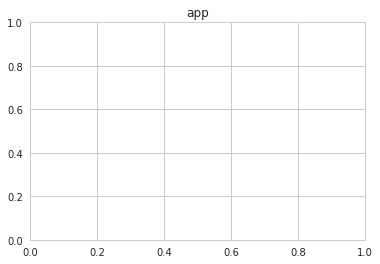

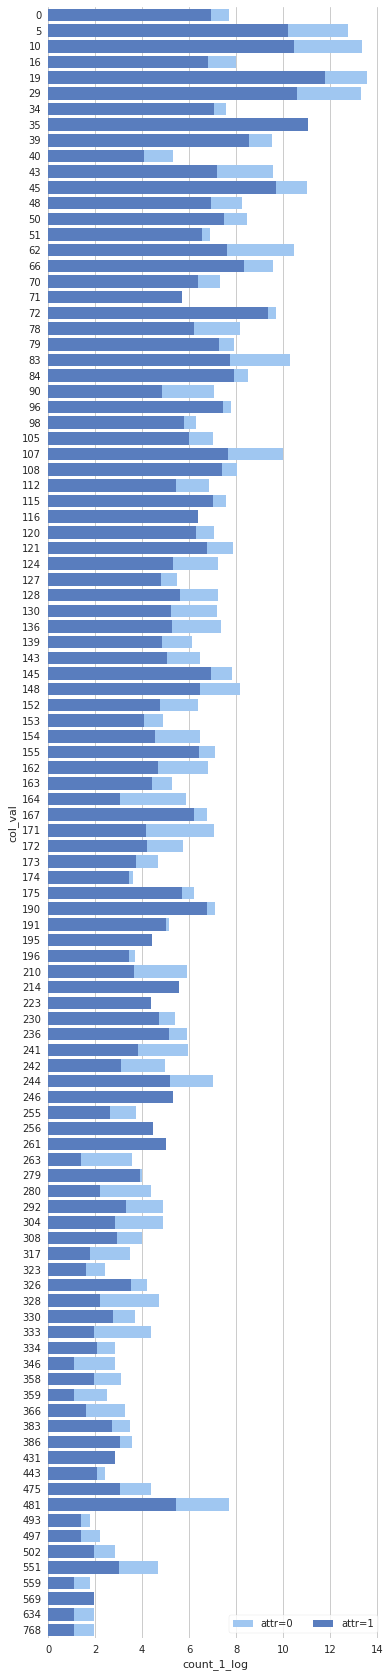

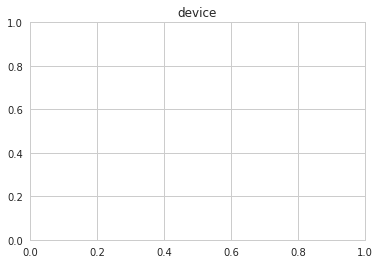

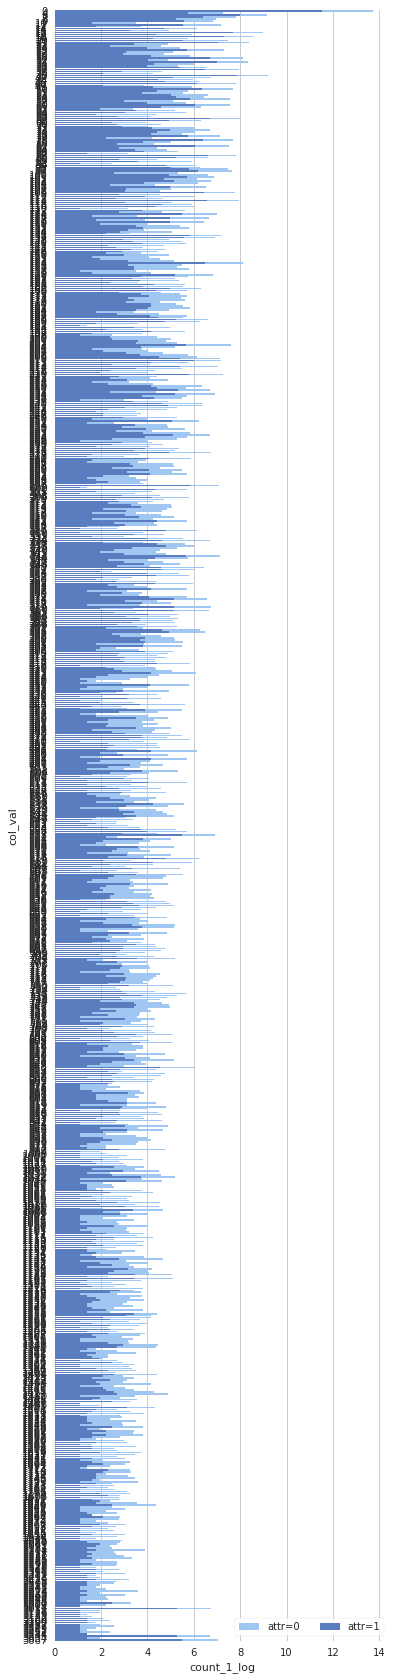

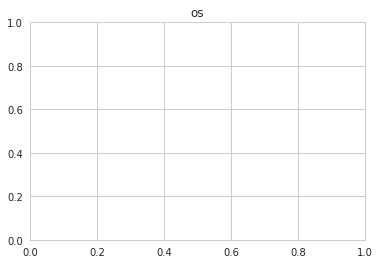

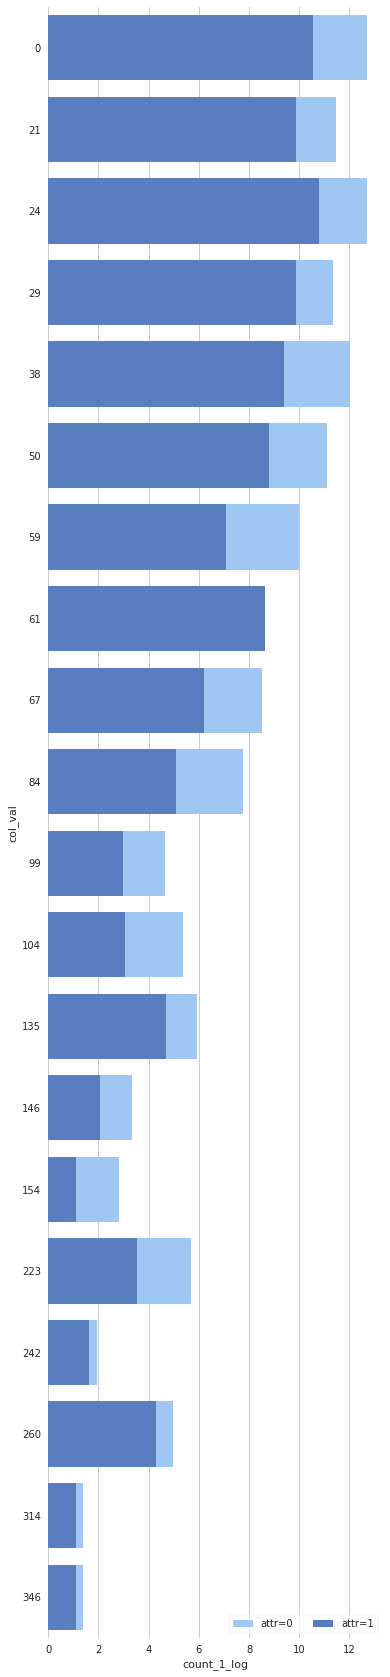

In [16]:
for col_name in ["channel", "app", "device", "os"]:
    df_dist = clean_cache_df_dist[col_name]
    plt.clf()
    plt.title(col_name)
    f, ax = plt.subplots(figsize=(6, 30))

    sns.set_color_codes("pastel")
    sns.barplot(x="count_0_log", y="col_val", data=df_dist,
                label="attr=0", color="b", orient="h")

    sns.set_color_codes("muted")
    sns.barplot(x="count_1_log", y="col_val", data=df_dist,
                label="attr=1", color="b", orient="h")

    ax.legend(ncol=2, loc="lower right", frameon=True)

    sns.despine(left=True, bottom=True)

    plt.show()